<font size=8>Synthetic WOD explore and prep - TSM</font>

xxxx



In [1]:
import os
import dask
import numpy as np
import pandas as pd
import dask.array as dask
import dask.bag as db
from matplotlib import pyplot as plt
import xarray as xr
import xesmf
import pandas as pd
import geopandas

In [2]:
xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

## small local cluster

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36261,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:36949,Total threads: 2
Dashboard: /proxy/44381/status,Memory: 9.14 GiB
Nanny: tcp://127.0.0.1:46761,


## Big cluster

## synthetic WoD from CChapman

In [4]:
path = '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018'

In [5]:
ctd = xr.open_dataset(path+'/synthetic_wod_2018_ctd.nc')

In [6]:
ctd

<xarray.Dataset>
Dimensions:    (casts: 383, depth: 54)
Coordinates:
  * casts      (casts) int64 0 1 2 3 4 5 6 7 ... 375 376 377 378 379 380 381 382
  * depth      (depth) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
Data variables:
    longitude  (casts) float32 ...
    latitude   (casts) float32 ...
    time       (casts) datetime64[ns] ...
    temp       (casts, depth) float64 ...

In [7]:
ctd_DF = ctd.to_dataframe()
ctd_DF

longitude  latitude                          time  \
casts depth                                                             
0     0.541281    -258.484009    -4.240 2018-01-01 02:37:00.000242688   
      1.680735    -258.484009    -4.240 2018-01-01 02:37:00.000242688   
      2.939953    -258.484009    -4.240 2018-01-01 02:37:00.000242688   
      4.331522    -258.484009    -4.240 2018-01-01 02:37:00.000242688   
      5.869350    -258.484009    -4.240 2018-01-01 02:37:00.000242688   
...                       ...       ...                           ...   
382   1333.076050 -188.130997    -8.093 2018-12-02 03:37:59.999542272   
      1453.384399 -188.130997    -8.093 2018-12-02 03:37:59.999542272   
      1581.153687 -188.130997    -8.093 2018-12-02 03:37:59.999542272   
      1716.204712 -188.130997    -8.093 2018-12-02 03:37:59.999542272   
      1858.264038 -188.130997    -8.093 2018-12-02 03:37:59.999542272   

                        temp  
casts depth                   
0     0.541281     28.575226  
      1.680735     28.578278  
      2.939953     28.576155  
      4.331522     28.570927  
      5.869350     28.562220  
...                      ...  
382   1333.076050   3.166334  
      1453.384399   2.867480  
      1581.153687   2.572775  
      1716.204712   2.329263  
      1858.264038   2.127938  

[20682 rows x 4 columns]

In [8]:
ctd_DF = ctd_DF.reset_index(level=0).reset_index(level=0)

In [9]:
ctd_DF

,depth,casts,longitude,latitude,time,temp
0,0.541281,0,-258.484009,-4.240,2018-01-01 02:37:00.000242688,28.575226
1,1.680735,0,-258.484009,-4.240,2018-01-01 02:37:00.000242688,28.578278
2,2.939953,0,-258.484009,-4.240,2018-01-01 02:37:00.000242688,28.576155
3,4.331522,0,-258.484009,-4.240,2018-01-01 02:37:00.000242688,28.570927
4,5.869350,0,-258.484009,-4.240,2018-01-01 02:37:00.000242688,28.562220
...,...,...,...,...,...,...
20677,1333.076050,382,-188.130997,-8.093,2018-12-02 03:37:59.999542272,3.166334
20678,1453.384399,382,-188.130997,-8.093,2018-12-02 03:37:59.999542272,2.867480
20679,1581.153687,382,-188.130997,-8.093,2018-12-02 03:37:59.999542272,2.572775
20680,1716.204712,382,-188.130997,-8.093,2018-12-02 03:37:59.999542272,2.329263


In [10]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [11]:
ctd_DF = ctd_DF[['time','longitude','latitude','depth','temp']]
ctd_DF

,time,longitude,latitude,depth,temp
0,2018-01-01 02:37:00.000242688,-258.484009,-4.240,0.541281,28.575226
1,2018-01-01 02:37:00.000242688,-258.484009,-4.240,1.680735,28.578278
2,2018-01-01 02:37:00.000242688,-258.484009,-4.240,2.939953,28.576155
3,2018-01-01 02:37:00.000242688,-258.484009,-4.240,4.331522,28.570927
4,2018-01-01 02:37:00.000242688,-258.484009,-4.240,5.869350,28.562220
...,...,...,...,...,...
20677,2018-12-02 03:37:59.999542272,-188.130997,-8.093,1333.076050,3.166334
20678,2018-12-02 03:37:59.999542272,-188.130997,-8.093,1453.384399,2.867480
20679,2018-12-02 03:37:59.999542272,-188.130997,-8.093,1581.153687,2.572775
20680,2018-12-02 03:37:59.999542272,-188.130997,-8.093,1716.204712,2.329263


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

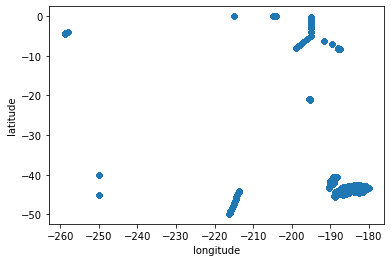

In [19]:
ctd_DF.plot(x='longitude',y='latitude',kind='scatter')

# Can I build one big DF from all the synthetic WOD nc's?

In [4]:
path = '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/'
str_part1 = 'synthetic_wod_2018_'
list_of_data_types = ['ctd','xbt','pfl','mrb','gld','osd']
list_of_file_paths = []
for type_ in list_of_data_types:
    list_of_file_paths.append(path+str_part1+type_+'.nc')
    
list_of_file_paths

['/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_ctd.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_xbt.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_pfl.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_mrb.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_gld.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_osd.nc']

In [5]:
concat_list = []
for file in list_of_file_paths:
    A = xr.open_dataset(file).to_dataframe().reset_index(level=0).reset_index(level=0)
    A = A.drop(columns='casts')
    id_string = file[60:63]
    total_rows = len(A)
    id_ = [id_string]*total_rows
    A["identifier"] = id_
    A = A[['longitude','latitude','temp','depth','time','identifier']]
    list_obj = A.to_dict('list')
    concat_list.append(list_obj)

In [6]:
DF = pd.DataFrame(concat_list)

In [7]:
DF

,longitude,latitude,temp,depth,time,identifier
0,"[-258.4840087890625, -258.4840087890625, -258....","[-4.239999771118164, -4.239999771118164, -4.23...","[28.575225830078125, 28.578277587890625, 28.57...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-01 02:37:00.000242688, 2018-01-01 02:...","[ctd, ctd, ctd, ctd, ctd, ctd, ctd, ctd, ctd, ..."
1,"[-241.6999969482422, -241.6999969482422, -241....","[-17.83329963684082, -17.83329963684082, -17.8...","[30.307804107666016, 30.049421310424805, 29.99...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-05 23:19:00.003204096, 2018-01-05 23:...","[xbt, xbt, xbt, xbt, xbt, xbt, xbt, xbt, xbt, ..."
2,"[-201.2480010986328, -201.2480010986328, -201....","[-17.815000534057617, -17.815000534057617, -17...","[28.25021743774414, 28.230382919311523, 28.204...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-01 00:59:02.760264704, 2018-01-01 00:...","[pfl, pfl, pfl, pfl, pfl, pfl, pfl, pfl, pfl, ..."
3,"[-194.97999572753906, -194.97999572753906, -19...","[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....","[29.924468994140625, 29.92742156982422, 29.926...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-01 00:00:00, 2018-01-01 00:00:00, 201...","[mrb, mrb, mrb, mrb, mrb, mrb, mrb, mrb, mrb, ..."
4,"[-204.0165557861328, -204.0165557861328, -204....","[-9.23270034790039, -9.23270034790039, -9.2327...","[30.139442443847656, 30.129802703857422, 30.11...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-01 03:11:15.000000512, 2018-01-01 03:...","[gld, gld, gld, gld, gld, gld, gld, gld, gld, ..."
5,"[-250.00027465820312, -250.00027465820312, -25...","[-40.00027847290039, -40.00027847290039, -40.0...","[13.765488624572754, 13.760740280151367, 13.75...","[0.5412807464599609, 1.680734634399414, 2.9399...","[2018-01-01 22:46:59.998169088, 2018-01-01 22:...","[osd, osd, osd, osd, osd, osd, osd, osd, osd, ..."


# smaller problem 

In [9]:
path = '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/'
str_part1 = 'synthetic_wod_2018_'
list_of_data_types = ['ctd','xbt','osd']
list_of_file_paths = []
for type_ in list_of_data_types:
    list_of_file_paths.append(path+str_part1+type_+'.nc')
    
list_of_file_paths

['/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_ctd.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_xbt.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_osd.nc']

In [24]:
DF = pd.DataFrame(columns=['longitude','latitude','temp','depth','time','identifier'])
for file in list_of_file_paths:
    A = xr.open_dataset(file).to_dataframe().reset_index(level=0).reset_index(level=0)
    A = A.drop(columns='casts')
    id_string = file[60:63]
    total_rows = len(A)
    id_ = [id_string]*total_rows
    A["identifier"] = id_
    A = A[['longitude','latitude','temp','depth','time','identifier']]
    DF = pd.concat([DF,A], axis=0)

In [25]:
DF

,longitude,latitude,temp,depth,time,identifier
0,-258.484009,-4.240000,28.575226,0.541281,2018-01-01 02:37:00.000242688,ctd
1,-258.484009,-4.240000,28.578278,1.680735,2018-01-01 02:37:00.000242688,ctd
2,-258.484009,-4.240000,28.576155,2.939953,2018-01-01 02:37:00.000242688,ctd
3,-258.484009,-4.240000,28.570927,4.331522,2018-01-01 02:37:00.000242688,ctd
4,-258.484009,-4.240000,28.562220,5.869350,2018-01-01 02:37:00.000242688,ctd
...,...,...,...,...,...,...
103,-250.006104,-45.015556,3.251007,1333.076050,2018-01-03 07:12:59.999256576,osd
104,-250.006104,-45.015556,3.014744,1453.384399,2018-01-03 07:12:59.999256576,osd
105,-250.006104,-45.015556,2.835078,1581.153687,2018-01-03 07:12:59.999256576,osd
106,-250.006104,-45.015556,2.700748,1716.204712,2018-01-03 07:12:59.999256576,osd


# full size problem

In [4]:
path = '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/'
str_part1 = 'synthetic_wod_2018_'
list_of_data_types = ['ctd','xbt','pfl','mrb','gld','osd']
list_of_file_paths = []
for type_ in list_of_data_types:
    list_of_file_paths.append(path+str_part1+type_+'.nc')
    
list_of_file_paths

['/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_ctd.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_xbt.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_pfl.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_mrb.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_gld.nc',
 '/g/data4/ul08/CARS_v2/Synthetic_WOD/2018/synthetic_wod_2018_osd.nc']

In [40]:
DF = pd.DataFrame(columns=['longitude','latitude','temp','depth','time','identifier'])
for file in list_of_file_paths:
    A = xr.open_dataset(file).to_dataframe().reset_index(level=0).reset_index(level=0)
    A = A.drop(columns='casts')
    id_string = file[60:63]
    total_rows = len(A)
    id_ = [id_string]*total_rows
    A["identifier"] = id_
    A = A[['longitude','latitude','temp','depth','time','identifier']]
    DF = pd.concat([DF,A], axis=0)

In [41]:
DF

,longitude,latitude,temp,depth,time,identifier
0,-258.484009,-4.240000,28.575226,0.541281,2018-01-01 02:37:00.000242688,ctd
1,-258.484009,-4.240000,28.578278,1.680735,2018-01-01 02:37:00.000242688,ctd
2,-258.484009,-4.240000,28.576155,2.939953,2018-01-01 02:37:00.000242688,ctd
3,-258.484009,-4.240000,28.570927,4.331522,2018-01-01 02:37:00.000242688,ctd
4,-258.484009,-4.240000,28.562220,5.869350,2018-01-01 02:37:00.000242688,ctd
...,...,...,...,...,...,...
103,-250.006104,-45.015556,3.251007,1333.076050,2018-01-03 07:12:59.999256576,osd
104,-250.006104,-45.015556,3.014744,1453.384399,2018-01-03 07:12:59.999256576,osd
105,-250.006104,-45.015556,2.835078,1581.153687,2018-01-03 07:12:59.999256576,osd
106,-250.006104,-45.015556,2.700748,1716.204712,2018-01-03 07:12:59.999256576,osd


In [42]:
DF.reset_index(drop=True,inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

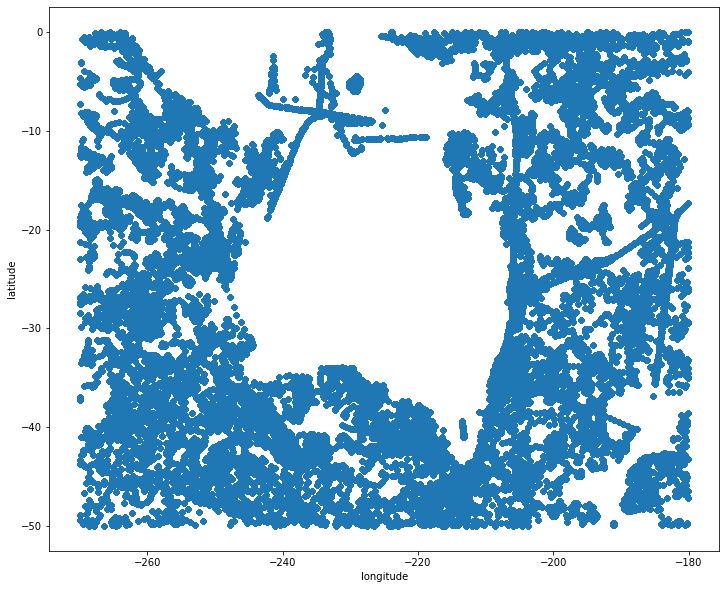

In [43]:
DF.plot(x='longitude',y='latitude',kind='scatter',figsize=(12,10))

In [44]:
DF

,longitude,latitude,temp,depth,time,identifier
0,-258.484009,-4.240000,28.575226,0.541281,2018-01-01 02:37:00.000242688,ctd
1,-258.484009,-4.240000,28.578278,1.680735,2018-01-01 02:37:00.000242688,ctd
2,-258.484009,-4.240000,28.576155,2.939953,2018-01-01 02:37:00.000242688,ctd
3,-258.484009,-4.240000,28.570927,4.331522,2018-01-01 02:37:00.000242688,ctd
4,-258.484009,-4.240000,28.562220,5.869350,2018-01-01 02:37:00.000242688,ctd
...,...,...,...,...,...,...
6085471,-250.006104,-45.015556,3.251007,1333.076050,2018-01-03 07:12:59.999256576,osd
6085472,-250.006104,-45.015556,3.014744,1453.384399,2018-01-03 07:12:59.999256576,osd
6085473,-250.006104,-45.015556,2.835078,1581.153687,2018-01-03 07:12:59.999256576,osd
6085474,-250.006104,-45.015556,2.700748,1716.204712,2018-01-03 07:12:59.999256576,osd


In [45]:
DS = DF.to_xarray()
DS

<xarray.Dataset>
Dimensions:     (index: 6085476)
Coordinates:
  * index       (index) int64 0 1 2 3 4 ... 6085472 6085473 6085474 6085475
Data variables:
    longitude   (index) float32 -258.5 -258.5 -258.5 ... -250.0 -250.0 -250.0
    latitude    (index) float32 -4.24 -4.24 -4.24 -4.24 ... -45.02 -45.02 -45.02
    temp        (index) float64 28.58 28.58 28.58 28.57 ... 2.835 2.701 2.576
    depth       (index) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
    time        (index) datetime64[ns] 2018-01-01T02:37:00.000242688 ... 2018...
    identifier  (index) object 'ctd' 'ctd' 'ctd' 'ctd' ... 'osd' 'osd' 'osd'

In [47]:
DS.nbytes/1e9

0.292102848

# export full files

In [48]:
DS.to_netcdf('/g/data/xv83/users/tm4888/PROJECTS/CARSv2/synthetic_wod_2018_all.nc')

In [49]:
DF.to_csv('/g/data/xv83/users/tm4888/PROJECTS/CARSv2/synthetic_wod_2018_all.txt', sep ='\t')

# How to bin upper 10m?

In [51]:
import xhistogram as xhist

In [20]:
DS

<xarray.Dataset>
Dimensions:     (index: 6085476)
Coordinates:
  * index       (index) int64 0 1 2 3 4 5 6 7 ... 101 102 103 104 105 106 107
Data variables:
    longitude   (index) float32 -258.5 -258.5 -258.5 ... -250.0 -250.0 -250.0
    latitude    (index) float32 -4.24 -4.24 -4.24 -4.24 ... -45.02 -45.02 -45.02
    temp        (index) float64 28.58 28.58 28.58 28.57 ... 2.835 2.701 2.576
    depth       (index) float64 0.5413 1.681 2.94 ... 1.716e+03 1.858e+03
    time        (index) datetime64[ns] 2018-01-01T02:37:00.000242688 ... 2018...
    identifier  (index) object 'ctd' 'ctd' 'ctd' 'ctd' ... 'osd' 'osd' 'osd'

# what does input data look like for DIVAnd?

https://github.com/Thomas-Moore-Creative/Diva-Workshops/blob/master/notebooks/2-Preprocessing/07-reading-data.ipynb
Big files

The so-called big files are intermediate files using by DIVA and DIVAnd. The format is rather simple: a tab-separated file containing the following variables:

longitude,
latitude,
field value (e.g., temperature, salinity, chlorophyll concentration, ...),
depth,
time,
measurement identifier.

In [19]:
example_nc_file = '/g/data/v14/tm4888/code/DIVAnd/Diva-Workshops/notebooks/data/dan_field_obs.nc'
example_txt_file = '/g/data/v14/tm4888/code/DIVAnd/Diva-Workshops/notebooks/data/data.txt'

In [21]:
nc = xr.open_dataset(example_nc_file)
nc

<xarray.Dataset>
Dimensions:  (dim2: 50, dim1: 50, nobs: 75)
Dimensions without coordinates: dim2, dim1, nobs
Data variables:
    f        (dim2, dim1) float64 ...
    x        (dim2, dim1) float64 ...
    y        (dim2, dim1) float64 ...
    mask     (dim2, dim1) int8 ...
    X        (nobs) float64 ...
    Y        (nobs) float64 ...
    F        (nobs) float64 ...
    Fe       (nobs) float64 ...
Attributes:
    title:    Synthetic example field

In [22]:
nc.to_dataframe()

f     x     y  mask         X         Y          F  \
dim2 dim1 nobs                                                               
0    0    0     18.501770   1.0   1.0     1  2.000000  7.000000  21.393897   
          1     18.501770   1.0   1.0     1  2.500000  7.500000  20.559378   
          2     18.501770   1.0   1.0     1  3.000000  8.000000  19.791725   
          3     18.501770   1.0   1.0     1  3.600000  8.600000  19.534783   
          4     18.501770   1.0   1.0     1  4.000000  9.000000  19.747455   
...                   ...   ...   ...   ...       ...       ...        ...   
49   49   70    19.573691  10.0  10.0     1  6.977271  9.075624  20.837458   
          71    19.573691  10.0  10.0     1  4.263193  6.813609  20.137384   
          72    19.573691  10.0  10.0     1  7.431265  3.703200  20.671430   
          73    19.573691  10.0  10.0     1  1.811527  1.366334  18.221062   
          74    19.573691  10.0  10.0     1  8.534788  8.239666  20.539901   

                       Fe  
dim2 dim1 nobs             
0    0    0     21.014987  
          1     21.321932  
          2     19.845385  
          3     20.234441  
          4     19.973824  
...                   ...  
49   49   70    20.395631  
          71    20.154373  
          72    20.819807  
          73    17.401283  
          74    21.386361  

[187500 rows x 8 columns]

In [23]:
pd.read_csv(example_txt_file)

,%year\tmonth\tday\thour\tminute\tsea-level-height\tflag1\tflag2
0,2004\t1\t1\t0\t0\t0.297\t0.003\t0
1,2004\t1\t1\t1\t0\t0.302\t0.002\t0
2,2004\t1\t1\t2\t0\t0.295\t0.006\t0
3,2004\t1\t1\t3\t0\t0.28\t0.003\t0
4,2004\t1\t1\t4\t0\t0.236\t0.004\t0
...,...
739,2004\t1\t31\t19\t0\t0.353\t0.011\t1
740,2004\t1\t31\t20\t0\t0.4\t0.013\t1
741,2004\t1\t31\t21\t0\t0.447\t0.012\t1
742,2004\t1\t31\t22\t0\t0.464\t0.017\t1


# Can we use the CC to load up this data?

In [ ]:
import cosima_cookbook as cc

In [ ]:
%%time
session = cc.database.create_session()
monthly_temp = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='temp', session=session, frequency='1 monthly', start_time='1987', end_time='2019')

In [ ]:
monthly_temp

# Note: below requires over 16GB of local RAM?

In [ ]:
%%time
session = cc.database.create_session()
daily_temp = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='temp', session=session, frequency='1 daily', start_time='1987', end_time='2019', return_dataset=True)

In [ ]:
daily_temp

## Load the model field (here from the 0.1 degree COSIMA model suite)

# switch

In [ ]:
model_temperature_dataset = daily_temp

# 34TB!

In [ ]:
model_temperature_dataset.nbytes/1e9

In [ ]:
grid010 = xarray.open_dataset('/g/data/ik11/grids/ocean_grid_01.nc')
grid010 = grid010.rename({'grid_x_C': 'xu_ocean', 'grid_y_C': 'yu_ocean',
                          'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'})

In [ ]:
grid010

In [ ]:
model_temperature_dataset = model_temperature_dataset.assign_coords({'geolat_t': grid010.geolat_t, 'geolon_t': grid010.geolon_t})
model_temperature_dataset = model_temperature_dataset.rename({'xt_ocean': 'x', 'yt_ocean': 'y',
                                                              'geolon_t': 'longitude', 'geolat_t': 'latitude'})


In [ ]:
model_temperature_dataset['temp'][0,0,:,:].plot()

In [ ]:
#lon_name = 'xt_ocean'
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + 360)  % 360})
#model_temperature_dataset.sortby(model_temperature_dataset)
#ds_out = ds_out.assign_coords({'lon': ds_out.lon - 100.})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] + (90+280)) % 360})
#model_temperature_dataset = model_temperature_dataset.assign_coords({lon_name: (model_temperature_dataset[lon_name] - 100)})

# I believe for xESMF to not bog down *ALL* space must be in one chunk?

In [ ]:
%%time
model_temperature_dataset = model_temperature_dataset.chunk({'time':1,'st_ocean':-1,'x':-1,'y':-1})

In [ ]:
model_temperature_dataset

# Load the World Ocean Database data


In [ ]:
WOD_base_file_path ='/g/data/ul08/WOD_2018'

year = 2018
WOD_file_name_stem = 'wod_'


obs_platform_type = ['ctd','xbt','pfl','mrb','gld','drb','osd']

WOD_object = dict(zip(obs_platform_type, [None]*len(obs_platform_type)))


for i_platform_type in obs_platform_type:
    
    WOD_object[i_platform_type] = xarray.open_dataset(os.path.join(WOD_base_file_path,str(2018),
                                                                   WOD_file_name_stem + i_platform_type + '_' + str(year) + '.nc') )
    


In [ ]:
platform_type = 'xbt'

WOD_lat = WOD_object[platform_type]['lat'].copy().values
WOD_lon = WOD_object[platform_type]['lon'].copy().values


In [ ]:
WOD_lon[WOD_lon>90] = WOD_lon[WOD_lon>90] - (270+90) 

In [ ]:
plt.scatter(WOD_object[platform_type]['lon'],WOD_object[platform_type]['lat'],s=25)
plt.scatter(WOD_lon,WOD_lat,s=10)


In [ ]:
ds_WOD_stations = xarray.Dataset()
ds_WOD_stations['longitude'] = xarray.DataArray(data=WOD_lon, dims=('casts'))
ds_WOD_stations['latitude'] = xarray.DataArray(data=WOD_lat, dims=('casts'))
ds_WOD_stations['time'] = xarray.DataArray(data=WOD_object[platform_type]['time'].values, dims=('casts'))

ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['longitude']>-280,
                                                       ds_WOD_stations['longitude']<-180),drop=True)
ds_WOD_stations = ds_WOD_stations.where(np.logical_and(ds_WOD_stations['latitude']>-50,
                                                       ds_WOD_stations['latitude']<0),drop=True)


In [ ]:
plt.contourf(model_temperature_dataset['temp']['xt_ocean'],model_temperature_dataset['temp']['yt_ocean'],
             model_temperature_dataset['temp'][0,0,:,:],25)
plt.scatter(ds_WOD_stations['longitude'],ds_WOD_stations['latitude'])

#plt.scatter(WOD_lon,WOD_lat,s=10)


In [ ]:
WOD_object['pfl']['z'].max()

In [ ]:
#model_temperature = model_temperature.drop({'x', 'y'}).cf.to_dataset()


#model_temperature = model_temperature.sel(time=ds_WOD_stations['time'].values,method='nearest')

#model_temperature = model_temperature.chunk({'time':5,'st_ocean':-1,'y':-1,'x':-1})

In [ ]:
max_depth = 800

n_levels = model_temperature_dataset['st_ocean'].sel(st_ocean=slice(0,max_depth)).size
n_casts  = ds_WOD_stations['casts'].size
KELVIN_TO_CELSIUS = -273.15



WOD_temperature_synthetic = xarray.DataArray(np.zeros([n_casts,n_levels],dtype=np.float32),
                                             dims=['casts','depth'],
                                             coords={'casts':ds_WOD_stations['casts'],
                                                     'depth':model_temperature_dataset['st_ocean'][0:n_levels].values}).to_dataset(name='temp')
WOD_temperature_synthetic['latitude'] = ds_WOD_stations['latitude']


WOD_temperature_synthetic['longitude'] = ds_WOD_stations['longitude']
WOD_temperature_synthetic['time'] = ds_WOD_stations['time']



#model_temperature_level = model_temperature_dataset['temp'].sel(st_ocean=slice(0,max_depth)) 


for i_level in range(25,n_levels):
    model_temperature_level = model_temperature_dataset['temp'].isel(st_ocean=i_level).load() 
    model_temperature_level = model_temperature_level + KELVIN_TO_CELSIUS
    
    
    regridder = xesmf.Regridder(model_temperature_level, ds_WOD_stations, 'bilinear', locstream_out=True) #,reuse_weights=True)
    
    WOD_temperature_synthetic_level = regridder(model_temperature_level)
    WOD_temperature_synthetic_level.to_netcdf(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') ) 
    
    
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level.sel(time=ds_WOD_stations['time'],method='nearest')
    
    


In [ ]:
WOD_temperature_synthetic_level

In [ ]:


for i_level in range(0,n_levels):
    #Get the slice for the current synthetic layer
    WOD_temperature_synthetic_level = xarray.open_dataset(os.path.join('/g/data4/ul08/CARS_v2/Synthetic_WOD/staging', 
                                                           'WOD_synthetic_' + platform_type + '_2018_' + 'level_' + str(i_level) +  '.nc') )
    WOD_temperature_synthetic['temp'][:,i_level] = WOD_temperature_synthetic_level['__xarray_dataarray_variable__'].sel(time=ds_WOD_stations['time'],method='nearest')
    WOD_temperature_synthetic_level.close()

In [ ]:
WOD_temperature_synthetic['temp'][20,:].plot()

In [ ]:
model_temperature_level

In [ ]:
model_temperature_level

In [ ]:
plt.scatter(WOD_temperature_synthetic['longitude'],WOD_temperature_synthetic['latitude'],c=WOD_temperature_synthetic['temp'][:,0],vmin=10,vmax=35)
plt.colorbar()

In [ ]:
model_temperature_level[0,:,:].plot(vmin=10,vmax=35)

In [ ]:
model_temperature_level

In [ ]:
regridder.to_netcdf('/g/data4/ul08/CARS_v2/regrid_weights_xbt.nc')

In [ ]:
test_xbt.compute()

In [ ]:
unique_days = np.unique(ds_WOD_stations['time.dayofyear'])

In [ ]:
for i_day in unique_days:
    
    model_temperature_dayofyear = model_temperature.sel(time=model_temperature['time'].dt.dayofyear.isin([i_day]))
    WOD_time_index = ds_WOD_stations['time'].dt.dayofyear.isin([i_day])
    ds_WOD_stations_dayofyear = ds_WOD_stations.where(WOD_time_index,drop=True)
    

    dsa
    

In [ ]:
WOD_time_index

In [ ]:
ds_WOD_stations_dayofyear

In [ ]:
ds_WOD_stations

In [ ]:
regridder = xesmf.Regridder(model_temperature, ds_WOD_stations, 'bilinear', locstream_out=True)


In [ ]:
regridder

In [ ]:
WOD_temperature_synthetic = regridder(model_temperature).compute()



In [ ]:
WOD_temperature_synthetic

In [ ]:
model_temperature

In [ ]:
WOD_temperature_synthetic['temp'][0,:,0].plot()

In [1]:
client.shutdown()

NameError: name 'client' is not defined